In [19]:
using Plots, JSON

include("src/loader.jl")
include("src/solver.jl")
include("src/simulator.jl")
include("src/dynamic.jl")
include("src/profile_generator.jl")
include("src/classifier.jl")

filename = "data/profiles.csv";

In [73]:
period_length = 7 * 24;

load_new = true;

if load_new
    time_by_week, wind_by_week, solar_by_week = load_by_periods(filename, period_length);
    time_train, wind_train, solar_train, time_val_full, wind_val_full, solar_val_full = 
    train_val_split(time_by_week, wind_by_week, solar_by_week,
    years_train = [2018, 2015, 2016, 2017],
    years_val = [2014]
    );
end;

In [74]:
N_CLASSES = 5;
classification_function = classify_uniform_thresholds;

classes_probas, classes_train, classes_val = classification_function(wind_train, solar_train, wind_val_full, solar_val_full, N_CLASSES);

# Count the number of profiles in each class in the training set and validation set
count_classes_train = [sum(classes_train .== i) for i in 1:N_CLASSES]
count_classes_val = [sum(classes_val .== i) for i in 1:N_CLASSES]

println("Number of profiles in each class in the training set: ", count_classes_train)
println("Number of profiles in each class in the validation set: ", count_classes_val)

Number of profiles in each class in the training set: [11, 48, 83, 58, 7]
Number of profiles in each class in the validation set: [7, 19, 20, 6, 1]


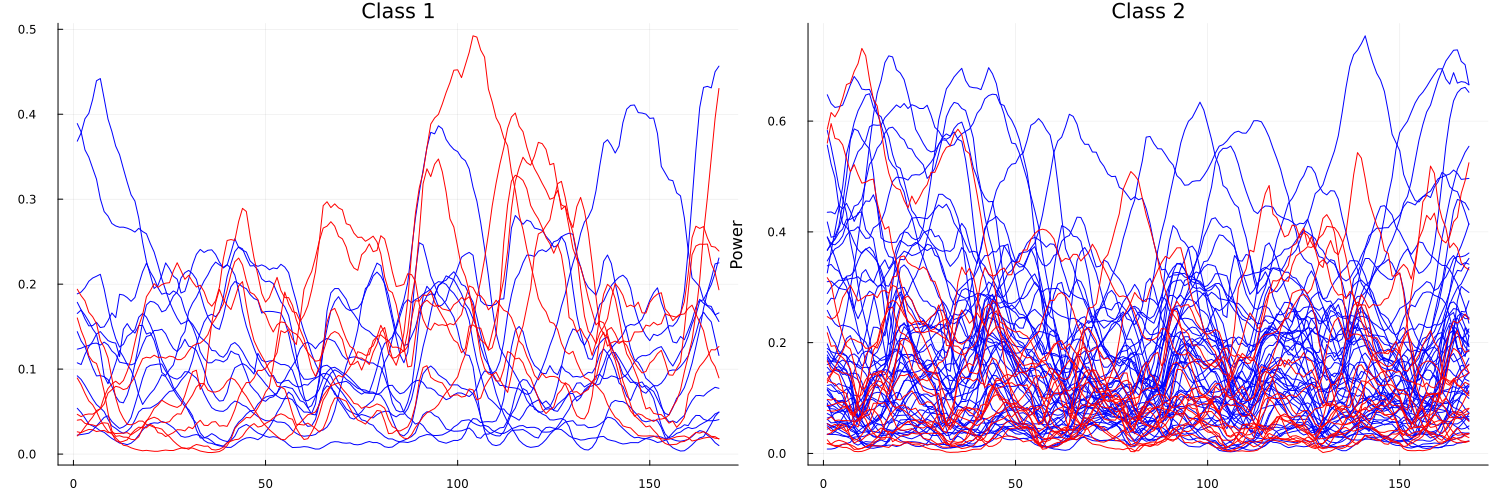

In [75]:
# Plot the profiles in the first and second class of the training set
plt_list = []
for class in 1:2
    plt = plot(xlabel="Time", ylabel="Power", title="Class $(class)")

    for profile in wind_train[classes_train .== class, :]
        plot!(plt, profile, label="", color = "blue")
    end
    # Add the profiles from the validation set

    for profile in wind_val_full[classes_val .== class, :]
        plot!(plt, profile, label="", color = "red")
    end
    push!(plt_list, plt)
end


plot(plt_list..., layout=(1, 2), size=(1500, 500))

We use only the first 10 week of the validation data to make the computes faster, for now

In [76]:
T = 10
time_val = time_val_full[1:T]
wind_val = wind_val_full[1:T]
solar_val = solar_val_full[1:T];

print("Validation data: ", length(wind_val)," periods of ", period_length, " hours each\n");

Validation data: 10 periods of 168 hours each


# Dynamic Programming, simple approach
- We denote by $x^s_t$ the state of the system at time $t$, where $x^s_t$ is the current stock in the tank.
- To remove complexity, we use a discrete state space, where $x^s_t$ take values by e.g. 1/10th of the tank capacity.
- The action at time $t$ is the choice of stock level we want to reach at time $t+1$
- The cost function is given by solving the MILP problem over the period $[t,t+1]$ (e.g usually a week)
- The dynamic programming equation is given by:
$$ V_T(x^s_T) = 0 $$
$$ V_t(x^s_t) = \min_{x^s_{t+1}} \left\{ \mathbb{E}_{W^P, S^P} [C(x^s_t,x^s_{t+1}) + V_{t+1}(x^s_{t+1})] \right\} $$
where $C(x^s_t,x^s_{t+1})$ is the cost of reaching $x^s_{t+1}$ from $x^s_t$ over the period $[t,t+1]$ (given by the MILP solver)

In [77]:
N_STATES = 10 # States in tenth of the tank capacity
states = [(i / N_STATES) * TANK_CAPA for i in 0:N_STATES];
# Number of weeks used for the computation of the expected values
N_EV = 10;

In [78]:
discount_factor = 0.9

V, policy = dynamic_solver(
    T,
    period_length = period_length,
    wind_train = wind_train,
    solar_train = solar_train,
    classes_train = classes_train,
    classes_probas = classes_probas,
    profiles_generator = generate_period_from_day,
    n_ev_compute = N_EV,
    states = states,
    discount_factor = discount_factor,
    verbose = true
);

Using 8 threads
Period 10
Period 9
Period 8
Period 7
Period 6
Period 5
Period 4
Period 3
Period 2
Period 1


## Policy simulator
- We can use the dynamic programming equation to simulate the effect of a given policy
- We compute the operationnal cost over a full year, and compare it to the optimal cost

In [79]:
initial_stock_index = 1
initial_stock = states[initial_stock_index]
initial_charge = 0.

print("Expected cost: $(sum(V[initial_stock_index, :, 1] .* classes_probas)) €\n")



output_simulation = simulator(
    solar_val = solar_val,
    wind_val = wind_val,
    classes_val = classes_val,
    states = states,
    policy = policy,
    initial_stock = initial_stock,
    initial_charge = initial_charge,
    verbose = false
);

print("Total cost: $(output_simulation["cost"]) €\n")

Expected cost: 8.923404550697634e6 €
Total cost: 1.5410008636647243e7 €


In [80]:
overall_time = []

for t in 1:T
    append!(overall_time, time_val[t])
end

## Compare with the MILP solution & the no policy solution

In [81]:
output_milp = optimal(
    solar_val = solar_val,
    wind_val = wind_val,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

In [82]:
output_no_policy = simulator_no_policy(
    solar_val = solar_val,
    wind_val = wind_val,
    states = states,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

In [83]:
policy_cost = output_simulation["cost"]
no_policy_cost = output_no_policy["cost"]
milp_cost = output_milp["operating_cost"]

policy_gap = trunc(100 * (policy_cost - milp_cost) / milp_cost, digits=2)
no_policy_gap = trunc(100 * (no_policy_cost - milp_cost) / milp_cost, digits=2)

print("Policy cost: $(policy_cost) €\n")
print("No policy cost: $(no_policy_cost) €\n")
print("MILP cost: $(milp_cost) €\n")
print("Policy gap: $policy_gap %\n")
print("No policy gap: $no_policy_gap %\n")

Policy cost: 1.5410008636647243e7 €
No policy cost: 1.4013211084490456e7 €
MILP cost: 1.3989760341502886e7 €
Policy gap: 10.15 %
No policy gap: 0.16 %


In [84]:
# Keep those results in storage in a json file
json_content = JSON.parsefile("results/results.json")

println("Previous results: ", json_content)

if !haskey(json_content, "previous")
    json_content["previous"] = []
end

push!(json_content["previous"], Dict(
    "classifier" => string(classification_function),
    "period_length" => period_length,
    "n_classes" => N_CLASSES,
    "T" => T,
    "N_STATES" => N_STATES,
    "N_EV" => N_EV,
    "policy_cost" => policy_cost,
    "no_policy_cost" => no_policy_cost,
    "milp_cost" => milp_cost,
    "policy_gap" => policy_gap,
    "no_policy_gap" => no_policy_gap,
    "discount_factor" => discount_factor,
))

println("New results: ", json_content)

fileIO = open("results/results.json", "w")
JSON.print(fileIO, json_content, 4)
close(fileIO)

Previous results: Dict{String, Any}("previous" => Any[Dict{String, Any}("T" => 10, "milp_cost" => 2.438951411605017e6, "no_policy_gap" => 1.21, "policy_cost" => 4.300785412795097e6, "N_STATES" => 10, "n_classes" => 20, "no_policy_cost" => 2.4686383940951154e6, "policy_gap" => 76.33, "classifier" => "classify_kmeans", "N_EV" => 2, "period_length" => 72), Dict{String, Any}("T" => 20, "milp_cost" => 5.632610695664958e6, "no_policy_gap" => 1.09, "policy_cost" => 7.3443482937227115e6, "N_STATES" => 10, "n_classes" => 20, "no_policy_cost" => 5.694043248856264e6, "policy_gap" => 30.38, "classifier" => "classify_kmeans", "N_EV" => 2, "period_length" => 48), Dict{String, Any}("T" => 20, "milp_cost" => 5.632610695664958e6, "no_policy_gap" => 1.09, "policy_cost" => 8.1999674566155765e6, "N_STATES" => 10, "n_classes" => 20, "no_policy_cost" => 5.694043248856264e6, "policy_gap" => 45.58, "classifier" => "classify_uniform_thresholds", "N_EV" => 2, "period_length" => 48), Dict{String, Any}("T" => 20,

In [85]:
# Prepare the scatter plot of the production levels constraints
last_hour_by_period = [time_val[i][end] for i in 1:T]
# Compute the chain of action to take
action = policy[initial_stock_index, classes_val[1], 1]
action_result_by_period = [states[action]]
for t in 2:T
    class = classes_val[t]
    action = policy[action, class, t]
    append!(action_result_by_period, states[action])
end

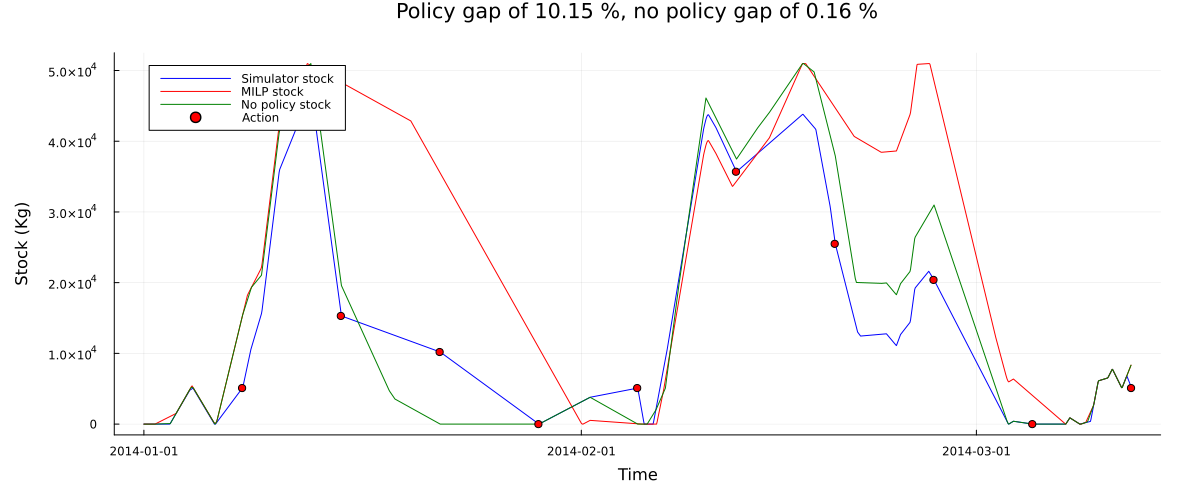

In [86]:
stock_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Stock (Kg)", title = "Policy gap of $policy_gap %, no policy gap of $no_policy_gap %")
plot!(stock_plot, overall_time,
    output_simulation["stock"], label = "Simulator stock", color = :blue) 
plot!(stock_plot, overall_time,
    output_milp["stock"][Not(end)], label = "MILP stock", color = :red)
plot!(stock_plot, overall_time,
    output_no_policy["stock"], label = "No policy stock", color = :green)

scatter!(stock_plot, last_hour_by_period, action_result_by_period, label = "Action", color = :red)

savefig(stock_plot, "plots/stock-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(stock_plot)

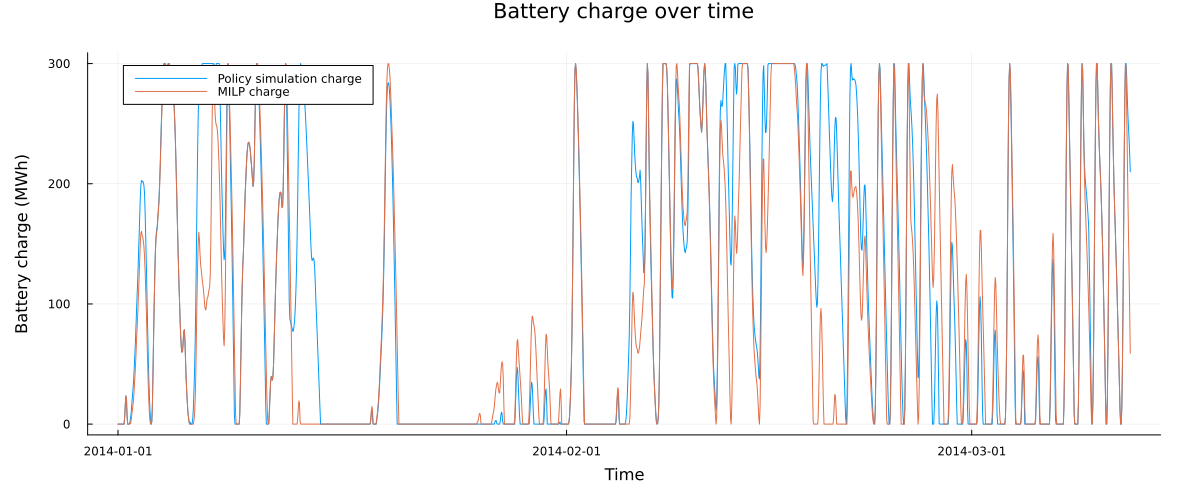

In [87]:
battery_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Battery charge (MWh)", title = "Battery charge over time")
plot!(battery_plot, overall_time, output_simulation["charge"], label = "Policy simulation charge")
plot!(battery_plot, overall_time, output_milp["charge"][Not(end)], label = "MILP charge")
savefig("plots/battery-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(battery_plot)

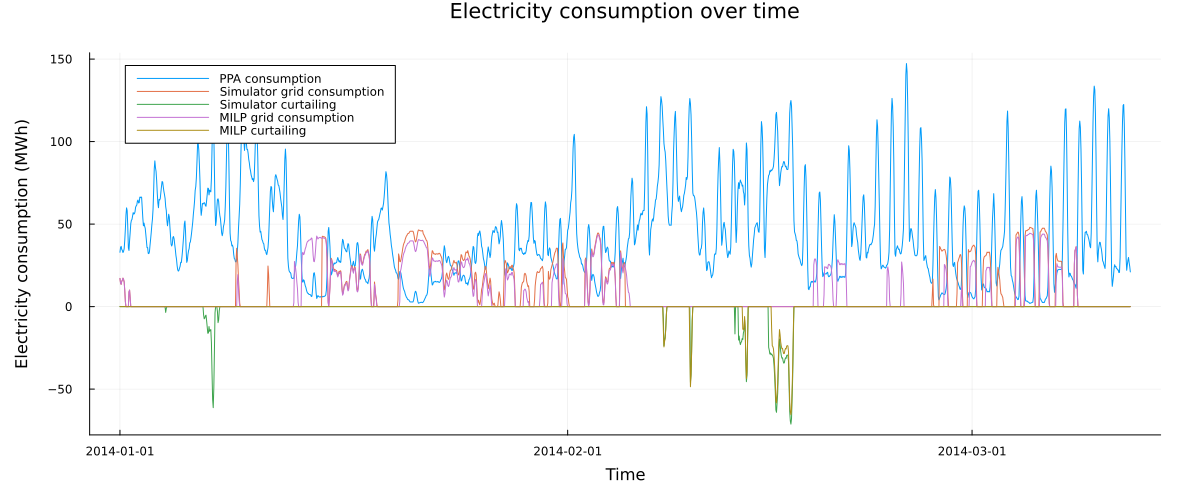

In [88]:
elec_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Electricity consumption (MWh)", title = "Electricity consumption over time")
plot!(elec_plot, overall_time, output_simulation["elec_ppa"], label = "PPA consumption")
plot!(elec_plot, overall_time, output_simulation["elec_grid"], label = "Simulator grid consumption")
plot!(elec_plot, overall_time, -output_simulation["curtailing"], label = "Simulator curtailing")
plot!(elec_plot, overall_time, output_milp["elec_grid"], label = "MILP grid consumption")
plot!(elec_plot, overall_time, -output_milp["curtailing"], label = "MILP curtailing")

savefig("plots/elec-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(elec_plot)

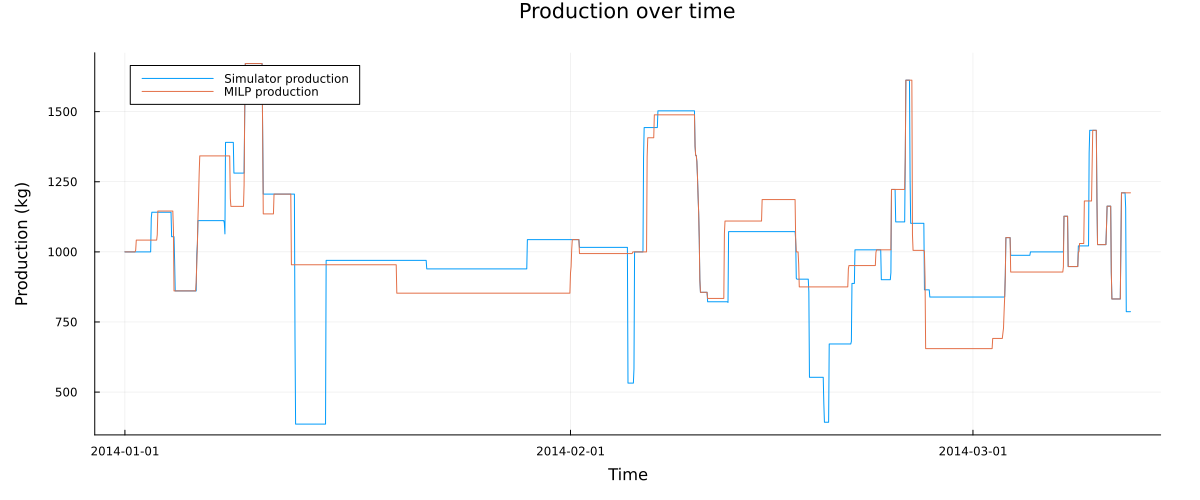

In [89]:
production = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Production (kg)", title = "Production over time")

plot!(production, overall_time, output_simulation["prod"], label = "Simulator production")
plot!(production, overall_time, output_milp["prod"], label = "MILP production")

savefig("plots/production-period=$period_length-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES)-N_CLASSES=$(N_CLASSES)-$(string(classification_function)).png")

plot(production)